In [1]:
"""
Summaries of USFS TreeMap linked to FIA plot data
Emphasis on 
    - Metrics of forest composition
    - Ecological gradients of species dominance
    - Forest structure (abundance, dominance, diversity, stand height)

Aggregate these statistics to FRP gridcells.

Author: maxwell.cook@colorado.edu
"""

import os, sys, time
import pandas as pd
import rioxarray as rxr
import xarray as xr
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import to_rgba

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

albers = 'EPSG:5070' # albers CONUS
utm = 'EPSG:32613' # UTM Zone 13N

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

print("Ready to go !")

Ready to go !


In [2]:
# load the aggregated FRP grids (regular 375m2 grids summarizing FRP from VIIRS)
fp = os.path.join(projdir,'data/spatial/mod/VIIRS/viirs_snpp_jpss1_afd_latlon_fires_pixar_gridstats.gpkg')
grid = gpd.read_file(fp)
print(f"\nThere are [{len(grid)}] grids across [{len(grid['Fire_ID'].unique())}] fires.\n")
print(f"\n{grid.columns}\n")

# Drop any dupicate grids ...
print(f"Dropping [{grid.duplicated(subset=['grid_index']).sum()}] duplicate grids.\n")
grid = grid.drop_duplicates(subset=['grid_index'], keep='first')

# check on fractional overlap distribution
print(f"Fractional overlap:\n{grid['overlap'].describe()}\n")
n_small = grid[grid['overlap'] < 0.05]['grid_index'].count() # less than 5% spatial overlap
print(f"Dropping [{n_small} ({round(n_small/len(grid)*100,2)}%)] grids with < 5% fractional overlap.")
grid = grid[grid['overlap'] >= 0.05] # remove these observations


There are [57232] grids across [100] fires.


Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_p95',
       'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp', 'dt_max_frp',
       'first_obs_date', 'last_obs_date', 't4_max', 't4_mean', 't5_max',
       't5_mean', 'day_count', 'night_count', 'frp_max_day', 'frp_max_night',
       'frp_csum_day', 'frp_csum_night', 'frp_mean_day', 'frp_mean_night',
       'frp_p90_day', 'frp_p90_night', 'frp_p95_day', 'frp_p95_night',
       'frp_p97_day', 'frp_p97_night', 'frp_p99_day', 'frp_p99_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fire_Name', 'geometry'],
      dtype='object')

Dropping [465] duplicate grids.

Fractional overlap:
count    56767.000000
mean         2.029756
std          2.004417
min          0.000003
25%          0.591083
50%          1.498852
75%          2.779104
max         24.470760
Name: overlap, dtype: float64

Dro

In [3]:
# Load the TreeMap (ca. 2016)
# Pixel values here denote the FIA plot ID ("tm_id")
# see '04a_TreeMap_FIA-Prep.ipynb'
# fp = os.path.join(maindir,'data/landcover/USFS/RDS_TreeMap/TreeMap2016.tif') # tm_id band
fp = os.path.join(projdir, "data/spatial/mod/USFS/TreeMap_2016_TMID_FORTYPCD.tif") # multi-band
treemap_da = rxr.open_rasterio(fp, masked=True, cache=False).squeeze()
tmid_da = treemap_da.sel(band=1) # the "tm_id" band
fortyp_da = treemap_da.sel(band=2) # the fortypcd band

# Grab some raster metadata from one of the layers
shp, gt, wkt, nd = treemap_da.shape, treemap_da.spatial_ref.GeoTransform, treemap_da.rio.crs, treemap_da.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Data Type: {treemap_da[0].dtype}")

del treemap_da
gc.collect()

Shape: (2, 28724, 17006); 
GeoTransform: -1193295.0 30.0 0.0 2253345.0 0.0 -30.0; 
WKT: EPSG:5070; 
NoData Value: nan; 
Data Type: float32


67

In [4]:
# create a forest/non-forest grid
forest_mask = xr.where(~np.isnan(tmid_da), 1, 0)
# calculate the total forested pixels
# see __functions.py 'compute_band_stats'
forest_pct = compute_band_stats(grid, forest_mask, 'grid_index', attr='constant')
forest_pct.rename(columns={
    'pct_cover': 'forest_pct',
    'total_pixels': 'forest_pixels'
}, inplace=True)
forest_pct = forest_pct[forest_pct['constant'] == 1] # just forest pixels
forest_pct = forest_pct[['grid_index','forest_pixels','forest_pct']]

# how many forested grids are there? (>50%)
n_forest = len(forest_pct[forest_pct['forest_pct'] > 50])
print(f"\n[{round(n_forest/len(grid)*100,2)}%] predominantly forest grids.")
print(f"\n{forest_pct.head(3)}")

# Save as a GeoTIFF
out_fp = os.path.join(projdir, "data/spatial/mod/USFS/TreeMap_2016_forestmask.tif")
forest_mask.rio.to_raster(out_fp, compress='zstd', zstd_level=9, dtype='uint16', driver='GTiff')
print(f"Saved multi-band raster to: {out_fp}")

del forest_mask
gc.collect() # clean up


[86.59%] predominantly forest grids.

   grid_index  forest_pixels  forest_pct
0     1955419            169       100.0
1     1955420            182       100.0
2     1955421            169       100.0
Saved multi-band raster to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/USFS/TreeMap_2016_forestmask.tif


16

## Algorithmic Forest Type Code

Summary of the TreeMap Algorithmic Forest Type Code (FORTYPCD) within FRP grids. 

In [5]:
# also calculate the FORTYPCD
t0 = time.time()

# see __functions.py
grid_fortypcd = compute_band_stats(grid, fortyp_da, 'grid_index', attr='fortypcd')

# tidy columns in the summary table
grid_fortypcd['count'] = grid_fortypcd['count'].astype(int)
grid_fortypcd['total_pixels'] = grid_fortypcd['total_pixels'].astype(int)

# load the species lookup table
fp = os.path.join(projdir,'data/tabular/mod/treemap_fortypcd_species_mapping.csv')
species_df = pd.read_csv(fp)
species_df = species_df[['FORTYPCD','SpeciesName']]
species_df.rename(columns={
    'FORTYPCD': 'fortypcd',
    'SpeciesName': 'fortypnm'
}, inplace=True)

# join the forest name
grid_fortypcd = grid_fortypcd.merge(species_df, on='fortypcd', how='left')
print(f"\n{grid_fortypcd.head(3)}")

t1 = (time.time() - t0) / 60
print(f"\nTotal elapsed time: {t1:.2f} minutes.")
print("\n~~~~~~~~~~\n")

del fortyp_da # clean up 
gc.collect()


   grid_index  fortypcd  count  total_pixels  pct_cover  \
0     1955419       182     46           169  27.218935   
1     1955419       201     38           169  22.485207   
2     1955419       221     12           169   7.100592   

                 fortypnm  
0  Rocky Mountain juniper  
1             Douglas-fir  
2          Ponderosa pine  

Total elapsed time: 0.48 minutes.

~~~~~~~~~~



15



Species making up 97% of the total: 

                            fortypnm    count  fraction  c_fraction
27                    Lodgepole pine  2070538  0.251100    0.251100
40                    Ponderosa pine  2051669  0.248812    0.499911
0                              Aspen   885627  0.107402    0.607314
18  Engelmann spruce / subalpine fir   807791  0.097963    0.705277
13                       Douglas-fir   479907  0.058200    0.763477
39         Pinyon / juniper woodland   394872  0.047887    0.811364
17                  Engelmann spruce   272331  0.033026    0.844390
46                     Subalpine fir   202642  0.024575    0.868965
21                         Grand fir   179312  0.021746    0.890711
53                         White fir   169961  0.020612    0.911322
43            Rocky Mountain juniper   167102  0.020265    0.931587
12            Deciduous oak woodland   163460  0.019823    0.951411
24                      Jeffrey pine    83154  0.010084    0.961495
6       

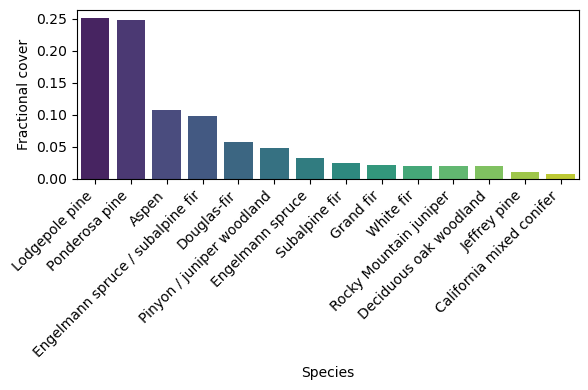

In [6]:
# Create a histogram of the forest species (prevalence)
fortyp = grid_fortypcd.copy() # make a copy to work with
fortyp = fortyp[fortyp['count'] > 0] # make sure there are some pixels
# calculate the landscape fraction (prevalence)
spp_pr = fortyp.groupby('fortypnm')['count'].sum().reset_index()
spp_pr['fraction'] = spp_pr['count'] / spp_pr['count'].sum()
spp_pr = spp_pr.sort_values(by='fraction', ascending=False)
# which species make up 97% of observations?
spp_pr['c_fraction'] = spp_pr['fraction'].cumsum()
top_species = spp_pr[spp_pr['c_fraction'] <= 0.97]
print(f"\n\nSpecies making up 97% of the total: \n\n{top_species}\n\n")

del fortyp, spp_pr
gc.collect()

# plot it
plt.figure(figsize=(6, 4))
sns.barplot(data=top_species, x='fortypnm', y='fraction', palette='viridis')
plt.xlabel('Species')
plt.ylabel('Fractional cover')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [7]:
# Aggregate species into forest groups
# These groups represent common pairings for the Southern Rockies
spp_grouping = {
    'pinyon|juniper': 'Piñon-juniper',
    'engelmann spruce|subalpine fir': 'Spruce-fir',
    'ponderosa pine|jeffrey': 'Ponderosa', 
    'lodgepole pine': 'Lodgepole',
    'aspen': 'Aspen',
    'douglas-fir|grand fir|white fir': 'Mixed-conifer',
    'oak': 'Oak-woodland',
}

# create the remap table
spp_remap = {} # dictionary to store the remap values
# Iterate over groups to create the species remap dictionary
for keywords, spp_group in spp_grouping.items():
    # Find species matching the keywords
    spp = grid_fortypcd[grid_fortypcd['fortypnm'].str.contains(keywords, case=False, na=False)]
    # Add matching species to the remap dictionary
    spp_remap.update(
        {name: spp_group for name in spp['fortypnm'].unique()}
    )
    
# Apply the remap to create a new grouped species column
grid_fortypcd['fortypnm_gp'] = grid_fortypcd['fortypnm'].map(spp_remap).fillna(grid_fortypcd['fortypnm'])
# Verify the updated species groups
print(grid_fortypcd[['fortypnm', 'fortypnm_gp']].drop_duplicates().head(3))
print(f"\n{grid_fortypcd.columns}")

                 fortypnm    fortypnm_gp
0  Rocky Mountain juniper  Piñon-juniper
1             Douglas-fir  Mixed-conifer
2          Ponderosa pine      Ponderosa

Index(['grid_index', 'fortypcd', 'count', 'total_pixels', 'pct_cover',
       'fortypnm', 'fortypnm_gp'],
      dtype='object')


In [8]:
# Aggregate with the new species groupings
# Reacalculate the percent cover for each species group
grid_fortypgp = (
    grid_fortypcd.groupby(['grid_index','fortypnm_gp'], as_index=False)
    .agg(
        count=('count','sum'),
        total_pixels=('total_pixels','max'),
        pct_cover=('pct_cover','sum'),
    )
)
# Check on nulls introduced
print(f"\nNaNs: {grid_fortypgp['fortypnm_gp'].isna().sum()}\n")

# merge the forest percent
grid_fortypgp = grid_fortypgp.merge(forest_pct, on='grid_index', how='left')

print(f"Forest percent:\n{grid_fortypgp['forest_pct'].describe()}\n")
print(f"\n{grid_fortypgp.head(10)}\n")

del forest_pct, grid_fortypcd
gc.collect()


NaNs: 0

Forest percent:
count    252407.000000
mean         84.875965
std          23.445322
min           0.510204
25%          79.591837
50%          97.041420
75%         100.000000
max         100.000000
Name: forest_pct, dtype: float64


   grid_index      fortypnm_gp  count  total_pixels  pct_cover  forest_pixels  \
0       34602  Other hardwoods      1           181   0.552486            182   
1       34602    Piñon-juniper    148           181  81.767956            182   
2       34602        Ponderosa     32           181  17.679558            182   
3       34603            Aspen      1           167   0.598802            169   
4       34603     Oak-woodland      4           167   2.395210            169   
5       34603  Other hardwoods      3           167   1.796407            169   
6       34603    Piñon-juniper     95           167  56.886228            169   
7       34603        Ponderosa     64           167  38.323353            169   
8       34604     Oak-wood

221



Species making up 97% of the total: 

      fortypnm_gp    count  fraction  c_fraction
28      Ponderosa  2134823  0.258896    0.258896
14      Lodgepole  2070538  0.251100    0.509996
33     Spruce-fir  1282764  0.155564    0.665560
0           Aspen   885627  0.107402    0.772963
18  Mixed-conifer   829180  0.100557    0.873520
27  Piñon-juniper   675125  0.081874    0.955394




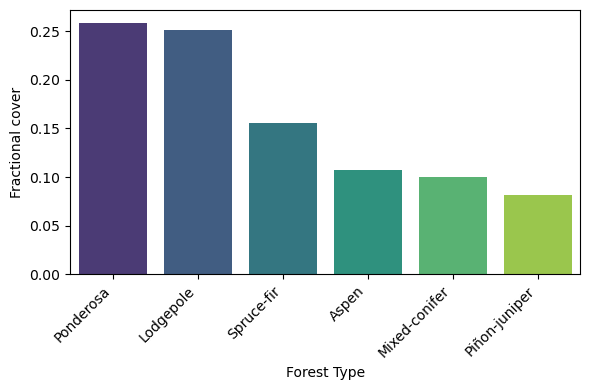

In [9]:
# Re-create the histogram of forest species (prevalence)
df = grid_fortypgp.copy() # make a copy to work with
# calculate the landscape fraction (prevalence)
spp_pr = df.groupby('fortypnm_gp')['count'].sum().reset_index()
spp_pr['fraction'] = spp_pr['count'] / spp_pr['count'].sum()
spp_pr = spp_pr.sort_values(by='fraction', ascending=False)
# which species make up 97% of observations?
spp_pr['c_fraction'] = spp_pr['fraction'].cumsum()
top_species = spp_pr[spp_pr['c_fraction'] <= 0.97]
print(f"\n\nSpecies making up 97% of the total: \n\n{top_species}\n\n")

del df, spp_pr # tidy up
gc.collect()

# plot it
plt.figure(figsize=(6, 4))
sns.barplot(data=top_species, x='fortypnm_gp', y='fraction', palette='viridis')
plt.xlabel('Forest Type')
plt.ylabel('Fractional cover')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [10]:
# check for duplicates, remove them
n = grid_fortypgp.duplicated(subset=['grid_index','fortypnm_gp','pct_cover']).sum()
print(f"Dropping [{n}] duplicate rows.")
grid_fortypgp = grid_fortypgp.drop_duplicates(subset=['grid_index','fortypnm_gp','pct_cover'])

Dropping [0] duplicate rows.


In [11]:
# save the TreeMap FORTYPCD table out.
out_fp = os.path.join(projdir,'data/tabular/mod/viirs_snpp_jpss1_gridstats_fortypnm_gp.csv')
grid_fortypgp.to_csv(out_fp)
print(f"Saved file to: {out_fp}")

Saved file to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/tabular/mod/viirs_snpp_jpss1_gridstats_fortypnm_gp.csv


In [12]:
# subset the grids to predominantly forested plots (>50% forested)
grid_forest = grid_fortypgp[grid_fortypgp['forest_pct'] > 50]
n_forest = len(grid_forest['grid_index'].unique())
print(f"{n_forest}/{len(grid)} [{round(n_forest/len(grid)*100,1)}%] gridcells are >50% forested.")
# Just work with forested grids from here on out:
del grid_fortypgp
gc.collect()

47047/54334 [86.6%] gridcells are >50% forested.


194

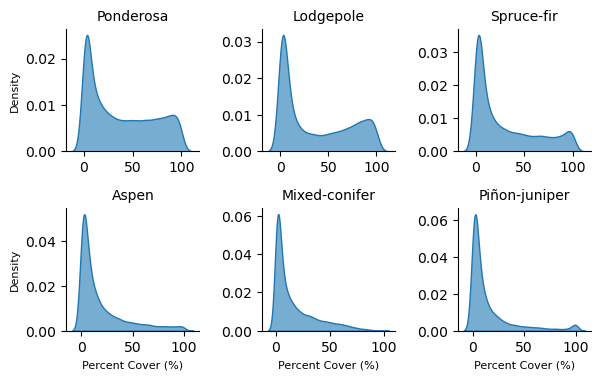

In [13]:
# plot the distribution of percent cover by forest types
df = grid_forest.copy()
df['fortypnm_gp'] = df['fortypnm_gp'].astype('category')
species_order = top_species['fortypnm_gp'].tolist()
df['fortypnm_gp'] = pd.Categorical(
    df['fortypnm_gp'],
    categories=species_order,
    ordered=True
)

# Create a FacetGrid with the specified order
g = sns.FacetGrid(
    data=df,
    col='fortypnm_gp',      
    col_wrap=3,             
    sharex=False,            
    sharey=False,            
    height=2,               
    aspect=1.2              
)

# Map a KDE plot to each facet
g.map(sns.kdeplot, 'pct_cover', fill=True, alpha=0.6)
# Customize the plot
g.set_titles("{col_name}")  # Use species names as titles
g.set_axis_labels("Percent Cover (%)", "Density", size=8)  # Axis labels
g.fig.set_size_inches(6,4)  # Set figure dimensions
plt.subplots_adjust(top=0.9)  # Adjust subplot spacing

del df
gc.collect()

plt.show()

In [14]:
grid_forest.columns

Index(['grid_index', 'fortypnm_gp', 'count', 'total_pixels', 'pct_cover',
       'forest_pixels', 'forest_pct'],
      dtype='object')

In [15]:
grid_forest['fortypnm_gp'].isna().sum()

0

In [16]:
print(len(grid_forest))
print(len(grid))

225005
54334


In [18]:
# join the forest type dataframe to our FRP gridcells
grid_forest_frp = grid.merge(grid_forest, on='grid_index', how='inner')
print(grid_forest_frp.columns)
print(len(grid_forest_frp))

Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_p95',
       'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp', 'dt_max_frp',
       'first_obs_date', 'last_obs_date', 't4_max', 't4_mean', 't5_max',
       't5_mean', 'day_count', 'night_count', 'frp_max_day', 'frp_max_night',
       'frp_csum_day', 'frp_csum_night', 'frp_mean_day', 'frp_mean_night',
       'frp_p90_day', 'frp_p90_night', 'frp_p95_day', 'frp_p95_night',
       'frp_p97_day', 'frp_p97_night', 'frp_p99_day', 'frp_p99_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fire_Name', 'geometry',
       'fortypnm_gp', 'count', 'total_pixels', 'pct_cover', 'forest_pixels',
       'forest_pct'],
      dtype='object')
232292


In [19]:
print(f"\nDropping [{grid_forest_frp['fortypnm_gp'].isna().sum()}] NaN rows.\n")
grid_forest_frp = grid_forest_frp[~grid_forest_frp['fortypnm_gp'].isna()]
print(len(grid_forest_frp))


Dropping [7287] NaN rows.

225005


In [20]:
print(f"\nSubsetting to top species groups:\n{top_species['fortypnm_gp'].unique()}")
grid_forest_frp = grid_forest_frp[grid_forest_frp['fortypnm_gp'].isin(top_species['fortypnm_gp'].unique())]
print(f"\n{len(grid_forest_frp['grid_index'].unique())}/{len(grid['grid_index'].unique())}")


Subsetting to top species groups:
['Ponderosa' 'Lodgepole' 'Spruce-fir' 'Aspen' 'Mixed-conifer'
 'Piñon-juniper']

47047/54334


['Piñon-juniper' 'Ponderosa' 'Aspen' 'Mixed-conifer' 'Lodgepole'
 'Spruce-fir']


Dropping 9395 [20.0%] gridcells w/ >0 max daytime FRP.


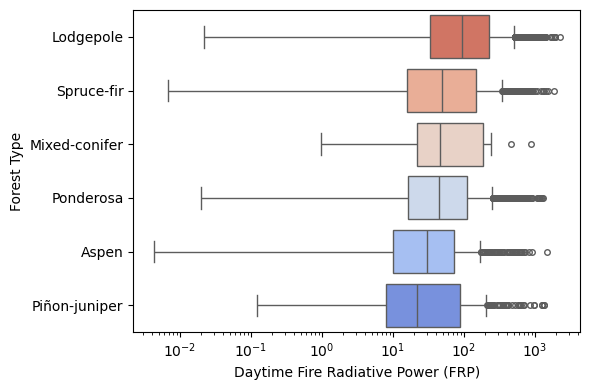


Saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/figures/FigureX_FORTYPCD_DominantSpecies_FRPmax_gp.png



In [21]:
# make some plots showing the distribution of FRP across forest types
# gather the dominant forest type
dfortyp = grid_forest_frp.loc[grid_forest_frp.groupby('grid_index')['pct_cover'].idxmax()]
print(dfortyp['fortypnm_gp'].unique())
print("\n")

# Retain only the daytime FRP measurements
n_small = len(dfortyp[dfortyp['frp_max_day'] == 0]) 
print(f"Dropping {n_small} [{round(n_small/len(dfortyp)*100,1)}%] gridcells w/ >0 max daytime FRP.")
dfortyp = dfortyp[(dfortyp['frp_max_day'] > 0)]

# create a dataframe with dominance (>90% of the same species)
dom = dfortyp[dfortyp['pct_cover'] > 90]

# Plot FRP by dominant forest type
# Find the median and sort the forest types by FRP
med = dom.groupby('fortypnm_gp')['frp_max_day'].median().sort_values(ascending=False)
sorted = med.index.tolist()

# setup the plot
plt.figure(figsize=(6, 4)) 

# boxplot
sns.boxplot(
    data=dom, 
    x='frp_max_day', 
    y='fortypnm_gp', 
    order=sorted, 
    palette='coolwarm_r', 
    fliersize=4,
    dodge=False)
plt.xscale('log') # log-scale FRP
plt.xlabel('Daytime Fire Radiative Power (FRP)')
plt.ylabel('Forest Type')
plt.tight_layout()
# save it out.
out_plot = os.path.join(projdir, 'figures/FigureX_FORTYPCD_DominantSpecies_FRPmax_gp.png')
plt.savefig(out_plot, dpi=300, bbox_inches='tight')

plt.show()
print(f"\nSaved to: {out_plot}\n")

In [22]:
# Run a statistical test between these groups
from scipy.stats import kruskal
import scikit_posthocs as sp

# Group FRP by forest type
grouped_frp = [dom[dom['fortypnm_gp'] == f]['frp_max_day'].values for f in sorted]
# Perform Kruskal-Wallis test
stat, p = kruskal(*grouped_frp)
print(f"\nKruskal-Wallis Test: H={stat:.3f}, p={p:.3e}\n")

# Dunn's test for pairwise comparisons
dunn = sp.posthoc_dunn(
    dom, val_col='frp_max_day', group_col='fortypnm_gp', p_adjust='bonferroni'
)
print(f"Dunn's test:\n{dunn}")


Kruskal-Wallis Test: H=485.525, p=1.062e-102

Dunn's test:
                      Aspen     Lodgepole  Mixed-conifer  Piñon-juniper  \
Aspen          1.000000e+00  1.188273e-45       0.716008   1.000000e+00   
Lodgepole      1.188273e-45  1.000000e+00       1.000000   4.333992e-55   
Mixed-conifer  7.160081e-01  1.000000e+00       1.000000   4.536668e-01   
Piñon-juniper  1.000000e+00  4.333992e-55       0.453667   1.000000e+00   
Ponderosa      3.999605e-06  1.506554e-54       1.000000   1.362850e-08   
Spruce-fir     1.394198e-08  2.652417e-31       1.000000   2.143032e-11   

                  Ponderosa    Spruce-fir  
Aspen          3.999605e-06  1.394198e-08  
Lodgepole      1.506554e-54  2.652417e-31  
Mixed-conifer  1.000000e+00  1.000000e+00  
Piñon-juniper  1.362850e-08  2.143032e-11  
Ponderosa      1.000000e+00  8.914875e-01  
Spruce-fir     8.914875e-01  1.000000e+00  


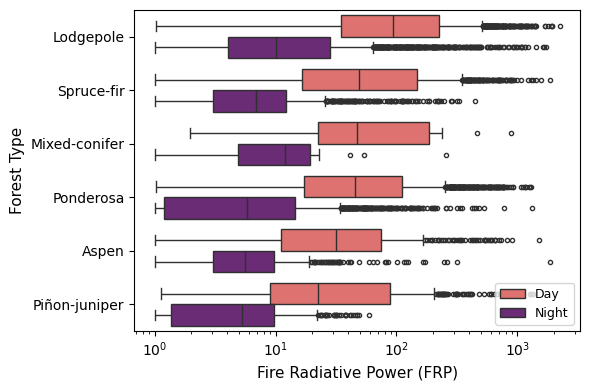


Saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/figures/FigureX_FORTYPCD_DominantSpecies_FRPmax_DayNight_gp.png



In [23]:
# Plot the Day vs. Night max FRP for dominant types
dom['frp_max_day'] = dom['frp_max_day'] + 1
dom['frp_max_night'] = dom['frp_max_night'] + 1

# Find the median and sort the forest types by FRP
med = dom.groupby('fortypnm_gp')['frp_max_day'].median().sort_values(ascending=False)
sorted = med.index.tolist()

# Reshape the data to long format for both day and night FRP
dom_l = pd.melt(
    dom, 
    id_vars=['fortypnm_gp'], 
    value_vars=['frp_max_day', 'frp_max_night'], 
    var_name='DayNight', 
    value_name='FRP'
)

# Map `Time` values for clearer labels
dom_l['DayNight'] = dom_l['DayNight'].map({'frp_max_day': 'Day', 'frp_max_night': 'Night'})

# Create the plot
plt.figure(figsize=(6, 4))

sns.boxplot(
    data=dom_l,
    x="FRP",
    y="fortypnm_gp",
    hue="DayNight",
    order=sorted,
    palette='magma_r',
    fliersize=3,
)

plt.xscale('log')  # Log-scale FRP
plt.xlabel('Fire Radiative Power (FRP)', fontsize=11)
plt.ylabel('Forest Type', fontsize=11)
plt.legend(title='', loc='lower right', fontsize=9)
plt.tight_layout()

# Save and show the plot
out_plot = os.path.join(projdir, 'figures/FigureX_FORTYPCD_DominantSpecies_FRPmax_DayNight_gp.png')
plt.savefig(out_plot, dpi=300, bbox_inches='tight')
plt.show()

print(f"\nSaved to: {out_plot}\n")

In [24]:
# Identify gridcells with some aspen component
aspen_idx = grid_forest_frp[grid_forest_frp['fortypnm_gp'] == 'Aspen']['grid_index'].unique() # list of grid indices
grid_aspen = grid_forest_frp[grid_forest_frp['grid_index'].isin(aspen_idx)]
# check how many aspen gridcells there are
n_aspen = len(grid_aspen['grid_index'].unique())
print(f"{n_aspen} [{round(n_aspen/len(grid_forest_frp['grid_index'].unique())*100,1)}%] gridcells with some aspen component.")

27335 [58.1%] gridcells with some aspen component.


Associate forest type: ['Lodgepole', 'Mixed-conifer', 'Piñon-juniper', 'Ponderosa', 'Spruce-fir']



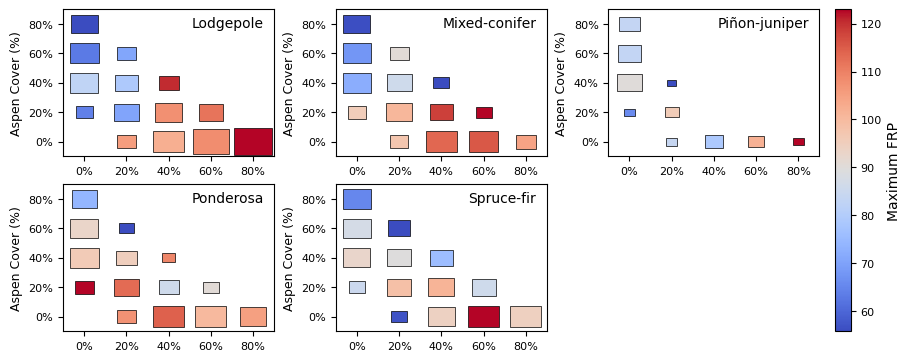

In [26]:
# waffle chart version
# create bins for species composition
bins = np.linspace(0, 100, 6) # 20% intervals
spps = [s for s in grid_aspen['fortypnm_gp'].unique() if s != 'Aspen'] # exclude aspen from species list
print(f"Associate forest type: {spps}\n")

# create grid data
df = grid_aspen.copy() # work from a copy
tiles = []  # Store tile data
for sp in spps:
    # Filter for co-occurrence
    df_sp = df[df['fortypnm_gp'].isin(['Aspen', sp])]
    # Pivot to create columns for Aspen and the species
    cover_df = (
        df_sp.pivot_table(
            index='grid_index', 
            columns='fortypnm_gp', 
            values='pct_cover', 
            fill_value=0
        ).reset_index()
         .rename(columns={'Aspen': 'aspen_cover', sp: f'{sp}_cover'})
    )
    # Make sure there are some of each species (aspen and other)
    cover_df['combined_cover'] = cover_df['aspen_cover'] + cover_df[f'{sp}_cover']
    cover_df = cover_df[cover_df['combined_cover'] > 50] # where one or both are dominant
    # Merge back with FRP data
    cover_df = cover_df.merge(
        grid_aspen[['grid_index','frp_max_day', 'frp_max_night']].drop_duplicates(), 
        on='grid_index', how='left')

    # Bin Aspen and species percent cover
    cover_df['aspen_bin'] = pd.cut(cover_df['aspen_cover'], bins, labels=range(len(bins) - 1))
    cover_df[f'{sp}_bin'] = pd.cut(cover_df[f'{sp}_cover'], bins, labels=range(len(bins) - 1))
    # Group by bins and calculate statistics
    grouped = cover_df.groupby(['aspen_bin', f'{sp}_bin'])
    counts = grouped.size().reset_index(name='freq')  # Frequency for tile size
    mean_frp = grouped['frp_max_day'].mean().reset_index(name='frp')  # Mean FRP for color

    # Merge statistics into a single DataFrame
    tiled_data = pd.merge(counts, mean_frp, on=['aspen_bin', f'{sp}_bin'])
    tiled_data['species'] = sp
    tiles.append(tiled_data)

    # Tidy up
    del df_sp, cover_df, grouped, counts, mean_frp, tiled_data
    gc.collect()

# Combine tile data
tiles_df = pd.concat(tiles, ignore_index=True)
tiles_df['log_frp'] = np.log10(tiles_df['frp'] + 1e-6) # add a small value to help with log-scaling

# Normalize tile sizes (scale frequency)
tiles_df['tile_size'] = (tiles_df['freq'] / tiles_df['freq'].max()) ** 0.2  # Square root scaling for better size balance

# Plotting the tile-scaled heatmap
n_cols = 3  # Number of columns in the facet grid
n_rows = int(np.ceil(len(spps) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(9,3.5), constrained_layout=True)
axes = axes.flatten()

# handle the normalization
vmin = tiles_df['log_frp'].min()
vmax = tiles_df['log_frp'].quantile()
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)  # Define color normalization based on raw FRP range

# log_frp_min = np.percentile(tiles_df['log_frp'], 10)
# log_frp_max = np.percentile(tiles_df['log_frp'], 90)

# make the grids
for i, sp in enumerate(spps):
    sp_data = tiles_df[tiles_df['species'] == sp]
    ax = axes[i]

    vmin = sp_data['frp'].min()
    vmax = sp_data['frp'].max()

    for _, row in sp_data.iterrows():
        x = int(row[f'{sp}_bin'])  
        y = int(row['aspen_bin'])  
        size = row['tile_size'] * 0.9
        
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
        color = plt.cm.coolwarm(norm(row['frp']))
        
        ax.add_patch(
            plt.Rectangle(
                (x - size / 2, y - size / 2), size, size, color=color, ec='black', lw=0.5
            )
        )

    # Formatting the axes
    # ax.set_title(sp, size=10)
    ax.text(
        0.95, 0.95, sp,  # x, y position in axis coordinates (top-right corner)
        transform=ax.transAxes,  # Use axis coordinates (0,0 is bottom-left, 1,1 is top-right)
        ha='right', va='top',  # Align the text to the top-right
        fontsize=10, color='black', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2')
    )
    ax.set_xlabel(f'')
    ax.set_ylabel('Aspen Cover (%)', size=9)
    ax.set_xticks(range(len(bins) - 1))
    ax.set_yticks(range(len(bins) - 1))
    ax.set_xticklabels([f'{int(b)}%' for b in bins[:-1]], size=8)
    ax.set_yticklabels([f'{int(b)}%' for b in bins[:-1]], size=8)
    ax.set_xlim(-0.5, len(bins) - 1.5)
    ax.set_ylim(-0.5, len(bins) - 1.5)

sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=norm)
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.05, pad=0.02)
cbar.set_label('Maximum FRP')
# cbar.set_label('Cumulative FRP', fontsize=10)
cbar.ax.tick_params(labelsize=8)

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

del df

out_plot = os.path.join(projdir, 'figures/FigureX_CoOccurring_Heatmap_FRPmax_Scaled_gp.png')
plt.savefig(out_plot, dpi=300, bbox_inches='tight')

plt.show()

## TreeMap Tree Table

Summary of the the TreeMap Tree Table information within forested grids identified above.

In [29]:
# Subset to forested grids before calculating the Tree Table stats
grid_ = grid[grid['grid_index'].isin(grid_forest['grid_index'].unique())]
grid_ = grid_.merge(grid_forest[['grid_index','forest_pixels','forest_pct']], on='grid_index', how='left')
grid_.columns

Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_p95',
       'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp', 'dt_max_frp',
       'first_obs_date', 'last_obs_date', 't4_max', 't4_mean', 't5_max',
       't5_mean', 'day_count', 'night_count', 'frp_max_day', 'frp_max_night',
       'frp_csum_day', 'frp_csum_night', 'frp_mean_day', 'frp_mean_night',
       'frp_p90_day', 'frp_p90_night', 'frp_p95_day', 'frp_p95_night',
       'frp_p97_day', 'frp_p97_night', 'frp_p99_day', 'frp_p99_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fire_Name', 'geometry',
       'forest_pixels', 'forest_pct'],
      dtype='object')

In [ ]:
# get the count/proportion of unique "tm_id" from TreeMap in grids
t0 = time.time()

# see __functions.py
grid_trees = compute_band_stats(grid_, tmid_da, 'grid_index', attr='tm_id')

# tidy columns in the summary table
grid_trees['count'] = grid_trees['count'].astype(int)
grid_trees['total_pixels'] = grid_trees['total_pixels'].astype(int)
grid_trees.rename(columns={
    'count': 'tmid_count',
    'pct_cover': 'tmid_pct'
}, inplace=True)

# load the TreeMap Tree Table
fp = os.path.join(maindir,'data/landcover/USFS/RDS_TreeMap/TreeMap2016_tree_table.csv')
tree_tbl = pd.read_csv(fp)
print(tree_tbl.columns)

# join the Tree Table to the grid data
grid_trees = grid_trees.merge(tree_tbl, on='tm_id', how='left')
print(f"\n{grid_trees.head(12)}")

t1 = (time.time() - t0) / 60
print(f"\nTotal elapsed time: {t1:.2f} minutes.")
print("\n~~~~~~~~~~\n")

del tmid_da, tree_tbl # clean up 
gc.collect()

Index(['tm_id', 'CN', 'STATUSCD', 'TPA_UNADJ', 'SPCD', 'COMMON_NAME',
       'SCIENTIFIC_NAME', 'SPECIES_SYMBOL', 'DIA', 'HT', 'ACTUALHT', 'CR',
       'SUBP', 'TREE', 'AGENTCD'],
      dtype='object')


In [49]:
# Calculate the Shannon diversity index for each tm_id
# Using the full list of trees in the Tree Table
# Based on total trees per tm_id and proportion
df = grid_trees.copy()
df['total_trees'] = df.groupby('tm_id')['TREE'].transform('sum')
df['p_species'] = df['TREE'] / df['total_trees'] # proportion
# Calculate Shannon diversity (H') for each tree row
df['shannon_h'] = -df['p_species'] * np.log(df['p_species'])

# Aggregate to calculate H' at the tm_id level
shannon_tmid = (
    df.groupby('tm_id', as_index=False)
    .agg(shannon_h=('shannon_h', 'sum')))
# subset columns
shannon_tmid = shannon_tmid[['tm_id','shannon_h']]
print(shannon_tmid.head(3))

# merge back to the grid data
grid_trees = grid_trees.merge(shannon_tmid, on='tm_id', how='left')
print(f"\n{grid_trees.columns}")

del shannon_tmid, df
gc.collect()

   tm_id  shannon_h
0     32   4.608039
1   1207   5.484286
2   1294   5.191912

Index(['grid_index', 'tm_id', 'tmid_count', 'total_pixels', 'tmid_pct', 'CN',
       'STATUSCD', 'TPA_UNADJ', 'SPCD', 'COMMON_NAME', 'SCIENTIFIC_NAME',
       'SPECIES_SYMBOL', 'DIA', 'HT', 'ACTUALHT', 'CR', 'SUBP', 'TREE',
       'AGENTCD', 'shannon_h'],
      dtype='object')


0

In [50]:
# Calculate the Tree Table statistics across tm_id/grid_index combinations
#### Abundance (trees/acre, scaled to per-pixel)
#### Dominance (live basal area, scaled to per-pixel)
#### Tree height (average/species)

# force species name to lower case
grid_trees.rename(columns={'COMMON_NAME': 'species'}, inplace=True)
grid_trees['species'] = grid_trees['species'].str.lower()
# tidy the live/dead column
grid_trees['live_dead'] = (grid_trees['STATUSCD'] == 1).astype(int)
# calculate the trees per acre, scaling by the acre/pixel factor
grid_trees['tree_tpa'] = (grid_trees['TREE'] * grid_trees['TPA_UNADJ']) * 0.222395 # trees/pixel
# calculate live basal area (balive) scaled by TPA
grid_trees['BA'] = np.pi * (grid_trees['DIA'] / 2) ** 2  # Basal area in square feet
grid_trees['BA_TPAsc'] = grid_trees['BA'] * grid_trees['tree_tpa']  # adjust based on tree abundance

# group by grid_index and plot identifier (tm_id)
# calculate statistics for live/dead seperately
# merge into a single dataframe

# live trees
live_metrics = (
    grid_trees[grid_trees['live_dead'] == 1]
    .groupby(['grid_index', 'tm_id', 'species'], as_index=False)
    .agg(
        tmid_pixels=('tmid_count','max'), # retains the tm_id pixel count
        tmid_pct=('tmid_pct','max'), # retain the percent of forested area
        forest_pixels=('forest_pixels','max'), # retain forest pixel count
        forest_pct=('forest_pct','max'), # retain forest percent for the grid
        shannon_h=('shannon_h','max'), # retains the tm_id shannon index
        balive=('BA_TPAsc', 'sum'),    # total BALIVE
        tpa_live=('tree_tpa', 'sum'),  # total live tree count (trees/acre)
        tree_ht_live=('ACTUALHT','mean') # average tree height
    )
)

# dead trees
dead_metrics = (
    grid_trees[grid_trees['live_dead'] == 0]
    .groupby(['grid_index', 'tm_id', 'species'], as_index=False)
    .agg(
        badead=('BA_TPAsc', 'sum'),    # Live basal area
        tpa_dead=('tree_tpa', 'sum'),  # Total live tree count (trees/acre)
        tree_ht_dead=('ACTUALHT','mean') # average tree height
    )
)

# combine live/dead balive
tree_metrics = live_metrics.merge(
    dead_metrics, 
    on=['grid_index', 'tm_id', 'species'], 
    how='outer'
).fillna(0)
# total acres for the tm_id (pixels * conversion factor)
tree_metrics['tmid_acres'] =  tree_metrics['tmid_pixels'] * 0.222395 
# subset to the tree metric columns
tree_metrics = tree_metrics[['grid_index','tm_id','tmid_pixels','tmid_acres',
                             'tmid_pct','forest_pct','species','shannon_h',
                             'balive','badead','tpa_live','tpa_dead',
                             'tree_ht_live','tree_ht_dead']]

# Add a "combined TPA" (live + dead)
# this may be important for lodgepole and spruce-fir in particular (beetle-kill)
tree_metrics['tpa_ld'] = tree_metrics['tpa_live'] + tree_metrics['tpa_dead']
tree_metrics['ba_ld'] = tree_metrics['balive'] + tree_metrics['badead']

print(f"\n{tree_metrics.head(12)}")
del live_metrics, dead_metrics, grid_trees
gc.collect()

KeyError: "Column(s) ['forest_pct', 'forest_pixels'] do not exist"

In [ ]:
# drop rows with 0 tm_id
tree_metrics = tree_metrics[tree_metrics['tmid_pixels'] != 0]

In [ ]:
unique_spp = tree_metrics['species'].unique()
unique_spp

In [ ]:
[s for s in unique_spp if 'pine' in str(s).lower()] # check pine species

In [ ]:
# Identify the primary species from the Tree Table
# identify the species which make up 97% of landscape
spp_pr = (
    tree_metrics.groupby('species', as_index=False)
    .agg(
        balive=('balive', 'sum'),
        ba_ld=('ba_ld', 'sum'),
        tpa_live=('tpa_live', 'sum'),
        tpa_ld=('tpa_ld', 'sum') # live+dead
    )
)
# calculate the fractions for both BALIVE and TPA
spp_pr['balive_f'] = spp_pr['balive'] / spp_pr['balive'].sum()
spp_pr['ba_ld_f'] = spp_pr['ba_ld'] / spp_pr['ba_ld'].sum() # live+dead
spp_pr['tpa_live_f'] = spp_pr['tpa_live'] / spp_pr['tpa_live'].sum()
spp_pr['tpa_ld_f'] = spp_pr['tpa_ld'] / spp_pr['tpa_ld'].sum() # live+dead
# sort values and gather the primary species
spp_pr = spp_pr.sort_values(by='ba_ld_f', ascending=False)
# which species make up 97% of observations?
spp_pr['balive_f_csum'] = spp_pr['balive_f'].cumsum()
spp_pr['ba_ld_f_csum'] = spp_pr['ba_ld_f'].cumsum() # live+dead
spp_pr['tpa_live_f_csum'] = spp_pr['tpa_live_f'].cumsum()
spp_pr['tpa_ld_f_csum'] = spp_pr['tpa_ld_f'].cumsum() # live+dead

metric = 'ba_ld_f_csum'
top_species = spp_pr[spp_pr[metric] <= 0.99]
print(f"\nSpecies making up 97% of *{metric}*: \n\n{top_species[['species','ba_ld','tpa_ld']]}\n\n")

del spp_pr
gc.collect()

In [ ]:
# Assess the species co-occurrence matrix to look for natural groupings
# Tests the "commonness" of species pairings
# Particularly, what to do with the "mixed conifers"
from itertools import combinations
from collections import Counter

# 1. Filter Tree Table to relevant species (most common)
spp_filter = ['white fir', 'grand fir', 'douglas-fir', 'engelmann spruce', 'subalpine fir', 'western larch']
top_spp_df = tree_metrics[tree_metrics['species'].str.lower().isin(spp_filter)]
# 2. Group species by tm_id
spp_tmid = (
    top_spp_df.groupby('tm_id')['species']
    .apply(lambda x: list(x.str.lower().unique()))  # Get unique species per tm_id
    .reset_index()
)
# 3. Generate all pairwise species combinations per tm_id
species_pairs = spp_tmid['species'].apply(
    lambda species_list: list(combinations(sorted(species_list), 2))
)
# Flatten list of all pairs
all_pairs = [pair for sublist in species_pairs for pair in sublist]
# 4. Count co-occurrences of each pair
pair_counts = Counter(all_pairs)
# Convert to DataFrame
pair_counts_df = (
    pd.DataFrame(pair_counts.items(), columns=['species_pair', 'coo_count'])
    .sort_values(by='coo_count', ascending=False)
)
# 5. Calculate co-occurrence percentage
total_tmid = len(spp_tmid)
pair_counts_df['coo_pct'] = pair_counts_df['coo_count'] / total_tmid * 100

# Inspect results
print(f"\n{pair_counts_df.head(30)}")

del spp_tmid, top_spp_df, species_pairs, pair_counts, pair_counts_df
gc.collect()

In [ ]:
# Aggregate species into forest groups
# These groups represent common pairings for the Southern Rockies
spp_grouping = {
    'pinyon|juniper': 'pinon-juniper',
    'engelmann spruce|subalpine fir|corkbark fir': 'spruce-fir',
    'limber|bristlecone|whitebark': 'subalpine-pine',
    'ponderosa pine|Jeffrey': 'ponderosa', 
    'lodgepole pine': 'lodgepole',
    'aspen': 'quaking aspen',
    'douglas-fir|grand fir|white fir|larch|cedar': 'mixed-conifer',
    'oak': 'oak-woodland',
    'cottonwood|willow': 'woody-riparian'
}

spp_remap = {} # dictionary to store the remap values
# Iterate over groups to create the species remap dictionary
for keywords, spp_group in spp_grouping.items():
    # Find species matching the keywords
    spp = tree_metrics[tree_metrics['species'].str.contains(keywords, case=False, na=False)]
    # Add matching species to the remap dictionary
    spp_remap.update({name: spp_group for name in spp['species'].unique()})

# Apply the remap to create a new grouped species column
tree_metrics['species_gp_n'] = tree_metrics['species'].map(spp_remap).fillna(tree_metrics['species'])
# Verify the updated species groups
print(tree_metrics[['species', 'species_gp_n']].drop_duplicates().head(10))
print(f"\n{tree_metrics.columns}")

In [ ]:
# re-aggregate the TreeMap characteristics by FRP grid/species combinations
# summarizes forest metrics by individual species present in the grid cell
# now, summarizes against the new forest groups made above
grid_tm = (
    tree_metrics.groupby(
        ['grid_index', 'species_gp_n'], as_index=False
    ).agg(
        tmid_n=('tm_id', 'nunique'), # number of unique tm_id contributing
        forest_pct=('forest_pct','max'), # retains the forest pixel count for the grid
        shannon_h=('shannon_h','mean'),
        balive=('balive', 'sum'),
        badead=('badead', 'sum'), 
        ba_ld=('ba_ld', 'sum'),
        tpa_live=('tpa_live', 'sum'),  
        tpa_dead=('tpa_dead', 'sum'),
        tpa_ld=('tpa_ld', 'sum'),
        tree_ht_live=('tree_ht_live', 'mean'),
        tree_ht_dead=('tree_ht_dead', 'mean')
    )
)

# Check results
print(f"\n{grid_tm.head(10)}\n")

del tree_metrics
gc.collect()

In [ ]:
# Re-assess the primary species after the regrouping
spp_pr = (
    grid_tm.groupby('species_gp_n', as_index=False)
    .agg(
        balive=('ba_ld','sum'),
        tpa_live=('tpa_ld', 'sum')
    )
)
# calculate the fraction
spp_pr['balive_f'] = spp_pr['balive'] / spp_pr['balive'].sum()
spp_pr['tpa_live_f'] = spp_pr['tpa_live'] / spp_pr['tpa_live'].sum()
# sort values and gather the primary species
spp_pr = spp_pr.sort_values(by='balive_f', ascending=False)
# which species make up 97% of observations?
spp_pr['balive_f_csum'] = spp_pr['balive_f'].cumsum()
spp_pr['tpa_live_f_csum'] = spp_pr['tpa_live_f'].cumsum()
top_species = spp_pr[spp_pr['balive_f_csum'] <= 0.97]
print(
    f"\nSpecies making up 97% of the total *tpa_live_f_csum*: \n\n",
    f"{top_species[['species_gp_n','balive_f','tpa_live_f']]}\n\n")

del spp_pr
gc.collect()

In [ ]:
# check on the aspen composition
# how many grids have at least some aspen component?
spp = 'quaking aspen'
spp_idx = grid_tm[grid_tm['species_gp_n'] == spp]['grid_index'].unique() # list of grid indices
grid_spp = grid_tm[grid_tm['grid_index'].isin(spp_idx)]
# check how many aspen gridcells there are
n_spp_grids = len(grid_spp['grid_index'].unique())
print(f"{n_spp_grids} [{round(n_spp_grids/len(grid_tm['grid_index'].unique())*100,1)}%] grids w/ any aspen")
del grid_spp
gc.collect()

In [ ]:
# Identify dominant species for each grid cell by 'balive' or 'tpa_live'
# print these summaries for all species
# percent of grids in which that species is dominant
metrics = ['tpa_ld', 'ba_ld']  # metrics to assess
for metric in metrics:
    print(f"\nDominance based on *{metric}*\n")
    dom_spp = (
        grid_tm.groupby('grid_index', as_index=False)
        .apply(lambda df: df.loc[df[metric].idxmax()])
        .reset_index(drop=True))
    # print the dominance for each major forest type
    for spp in top_species['species_gp_n'].unique():
        # Filter for grid cells where species is dominant
        spp_dominant = dom_spp[dom_spp['species_gp_n'] == spp]
        # Count the number of grid cells with aspen dominance
        n_dom = len(spp_dominant['grid_index'].unique())
        # Print the results
        total_grids = len(grid_tm['grid_index'].unique())
        spp_pct = round(n_dom / total_grids * 100, 1)
        print(f"\t~ {spp}: {n_dom} grids ({spp_pct}%)")
print("\n")
del dom_spp, spp_dominant
gc.collect()

In [ ]:
grid_tm.columns

In [ ]:
# filter to keep grids with our top/dominant species
# species groups making up 97% of gridcell area
grid_tm_dsp = grid_tm[grid_tm['species_gp_n'].isin(top_species['species_gp_n'].unique())]

# check how many this is compared to the total
n_grids = len(grid_tm['grid_index'].unique())
print(f"\n{round(len(grid_tm_dsp['grid_index'].unique()) / n_grids*100,3)}% grids w/ primary species\n")

# calculate how many grids are predominantly forested
n_forest = len(grid_tm_dsp[grid_tm_dsp['forest_pct'] > 50])
print(f"[{round(n_forest/len(grid_tm_dsp)*100,2)}%] predominantly forested grids.\n")

# Get the grid-level dominance and abundance proportions by species
# calculate the total balive and tpa for the grids
grid_totals = (
    grid_tm_dsp.groupby('grid_index', as_index=False)
    .agg(
        balive_total=('balive', 'sum'),
        badead_total=('badead', 'sum'),
        ba_ld_total=('ba_ld', 'sum'),
        tpa_live_total=('tpa_live', 'sum'),
        tpa_dead_total=('tpa_dead', 'sum'),
        tpa_ld_total=('tpa_ld', 'sum')
    )
)
# subset columns
grid_totals = grid_totals[['grid_index',
                           'balive_total','badead_total','ba_ld_total',
                           'tpa_live_total','tpa_dead_total','tpa_ld_total']]
# merge back to the grid data
grid_tm_dsp = grid_tm_dsp.merge(grid_totals, on='grid_index', how='left')

# calculate the species proportions (for live/dead)
# dominance (live/dead basal area)
grid_tm_dsp['sp_dominance_l'] = grid_tm_dsp['balive'] / grid_tm_dsp['balive_total']
grid_tm_dsp['sp_dominance_d'] = grid_tm_dsp['badead'] / grid_tm_dsp['badead_total']
grid_tm_dsp['sp_dominance_ld'] = grid_tm_dsp['ba_ld'] / grid_tm_dsp['ba_ld_total']

# abundance (live/dead TPA)
grid_tm_dsp['sp_abundance_l'] = grid_tm_dsp['tpa_live'] / grid_tm_dsp['tpa_live_total']
grid_tm_dsp['sp_abundance_d'] = grid_tm_dsp['tpa_dead'] / grid_tm_dsp['tpa_dead_total']
grid_tm_dsp['sp_abundance_ld'] = grid_tm_dsp['tpa_live'] / grid_tm_dsp['tpa_live_total']

del grid_totals

# cheack on the results
grid_tm_dsp[['grid_index','species_gp_n',
             'sp_dominance_l','sp_dominance_d','sp_dominance_ld',
             'sp_abundance_l','sp_abundance_d','sp_abundance_ld'
            ]].head(3)

In [ ]:
# Plot the distribution of dominance and abundance across forest species groups
# Sort species by mean dominance
sp_order = (
    grid_tm_frp.groupby('species_gp_n')['sp_dominance_ld']
    .mean().sort_values(ascending=False).index
)
# Reshape the data to long format for easier plotting
df_long = pd.melt(
    grid_tm_frp,
    id_vars=['species_gp_n'],
    value_vars=['sp_dominance_ld', 'sp_abundance_ld'],
    var_name='metric',
    value_name='value'
)

# Set up the plot
plt.figure(figsize=(6,4))
sns.boxplot(
    data=df_long,
    x='species_gp_n',
    y='value',
    hue='metric',
    order=sp_order,
    palette='muted',
    flierprops=dict(marker='o', markersize=1.2)
)

# Customize the plot
plt.title('Distribution of Dominance and Abundance by Species')
plt.xlabel('Species')
plt.ylabel('Metric Value')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric', loc='upper right', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [ ]:
# merge back to the frp data
grid_tm_frp = grid.merge(grid_tm_dsp, on='grid_index', how='right')
grid_tm_frp.columns

In [ ]:
del grid_tm_dsp, grid_tm
gc.collect()

In [ ]:
grid_tm_frp['species_gp_n'].unique()

In [ ]:
# Save this table out.
# First, extract centroid coords
df = grid_tm_frp.copy()
df = df.to_crs(4326) # WGS coords for lat/lon
df['grid_x'] = df.geometry.centroid.x  # Longitude (x-coordinate)
df['grid_y'] = df.geometry.centroid.y 
# remove the geomtry field before exporting
df.drop(columns=['geometry'], inplace=True)

# save the file.
out_fp = os.path.join(projdir,'data/tabular/mod/viirs_gridstats_treemap.csv')
df.to_csv(out_fp)
print(f"Saved file to: {out_fp}")

del df
gc.collect()

In [ ]:
# Explore the data ...

In [ ]:
# plot the distribution of percent cover by forest types
grid_tm_frp['species_gp_n'] = grid_tm_frp['species_gp_n'].astype('category')

species_order = top_species['species_gp_n'].tolist()
grid_tm_frp['species_gp_n'] = pd.Categorical(
    grid_tm_frp['species_gp_n'],
    categories=species_order,
    ordered=True
)

# Create a FacetGrid with the specified order
g = sns.FacetGrid(
    data=grid_tm_frp,
    col='species_gp_n',      
    col_wrap=3,             
    sharex=False,            
    sharey=False,            
    height=2,               
    aspect=1.2              
)

# Map a KDE plot to each facet
g.map(sns.kdeplot, 'sp_dominance_ld', fill=True, alpha=0.6)

# Customize the plot
g.set_titles("{col_name}")  # Use species names as titles
g.set_axis_labels("Dominance (BALIVE)", "Density", size=9)  # Axis labels
g.fig.set_size_inches(6,4)  # Set figure dimensions
plt.subplots_adjust(top=0.9)  # Adjust subplot spacing

# Show the plot
plt.show()

In [ ]:
# Species co-occurrence plot
# Threshold species presence where dominance/abundance > 1% of total
dt = 0.05
# Create a binary presence-absence matrix
pres_abs = (
    grid_tm_frp
    .pivot_table(index='grid_index', columns='species_gp_n', values='sp_dominance_ld', aggfunc='first')
    .fillna(0)
    .applymap(lambda x: 1 if x >= dt else 0)  # Convert to binary
)

# get the species names and matrix
species = pres_abs.columns
coo_mat = pd.DataFrame(0, index=species, columns=species)
# map across species combinations
for sp1, sp2 in combinations(species, 2):
    # Count co-occurrence (grids where both species are present)
    coo = np.sum(pres_abs[sp1] & pres_abs[sp2])
    coo_mat.loc[sp1, sp2] = coo
    coo_mat.loc[sp2, sp1] = coo  # Symmetry

# Optional: Normalize by the total number of grids for each species
species_totals = pres_abs.sum(axis=0)
norm_mat = coo_mat.div(species_totals, axis=0)

# Create a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(
    norm_mat, 
    annot=True, 
    fmt=".2f", 
    cmap="YlGnBu", 
    cbar_kws={'label': 'Co-Occurrence Frequency'}
)
plt.xlabel("Species")
plt.ylabel("Species")
plt.tight_layout()

out_png = os.path.join(projdir, 'figures/FigureX_Species_CoOccurrence.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# Plot maximum daytime FRP across dominance and abundance



In [ ]:
# Group by Conifer/Aspen
print(len(grid_tm_frp))
df = grid_tm_frp.copy()
df = df[df['species_gp_n'] != 'oak-woodland'] # remove the oak-woodland class
df['forest_phys'] = grid_tm_frp['species_gp_n'].apply(
    lambda x: 'conifer' if x != 'quaking aspen' else x)
print(df['forest_phys'].unique())
print(df['forest_phys'].value_counts())

In [ ]:
# create a 'conifer' column
df = grid_tm_frp.copy() # work with a copy
df = df[df['frp_max_day'] > 1] # filter out small FRP values

# label conifer/aspen, summarize percent cover
df['forest_phys'] = df['species_gp_n'].apply(lambda x: 'conifer' if x != 'quaking aspen' else x)
print(f"Forest classes: {df['forest_phys'].unique()}\n")

# aggregate statistics
df = (
    df.groupby(['grid_index', 'forest_phys'], as_index=False)
    .agg(
        ba_ld=('balive','sum'),
        tpa_ld=('tpa_live','sum'),
        abundance=('sp_abundance_ld','sum'),
        dominance=('sp_dominance_ld','sum')
    )
)

# filter to where there is some aspen or conifer
df = df[(df['abundance'] > 0)]

print(f"{len(df[df['forest_phys'] == 'quaking aspen'])} grids w/ some aspen.\n")
print(f"{df.head(3)}\n")

# Pivot to have one row per grid with aspen and conifer as columns
df_p = (
    df.pivot(index='grid_index', columns='forest_phys', values='dominance')
    .fillna(0)  # Fill missing values with 0
    .reset_index()
    .rename(columns={'quaking aspen': 'aspen', 'conifer': 'conifer'})
)

df_p['combined'] = df_p['aspen'] + df_p['conifer']
df_p = df_p[df_p['combined'] > 0.20] # greater than 50% combined dominance

# Add FRP metrics back to the DataFrame
df_p = df_p.merge(
    grid_tm_frp[['grid_index', 'frp_max_day']], on='grid_index', how='left'
)
print(f"{df_p.head(3)}\n")

# bin the data and plot the heatmap
bins = np.linspace(0, 1, 6)  # 10% intervals
df_p['aspen_bin'] = pd.cut(df_p['aspen'], bins, labels=bins[:-1])
df_p['conifer_bin'] = pd.cut(df_p['conifer'], bins, labels=bins[:-1])

# create the summarized data by bins (heatmap)
heatmap_da = df_p.groupby(['aspen_bin', 'conifer_bin']).frp_max_day.mean().unstack()
heatmap_da = heatmap_da.replace(0, np.nan)

# heatmap_da_log = np.log10(heatmap_da + 1e-6)

# plot it
plt.figure(figsize=(6, 4))

sns.heatmap(
    heatmap_da, 
    cmap='coolwarm', 
    annot=True, 
    fmt=".0f", 
    cbar_kws={'label': 'Maximum FRP'}
)

plt.title("Aspen/Conifer Co-occurrence", size=12, loc='center')
plt.xlabel('Conifer (%)')
plt.ylabel('Aspen (%)')

out_plot = os.path.join(projdir, 'figures/FigureX_ConiferAspen_Heatmap_FRPmax_Tree.png')
plt.savefig(out_plot, dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# scaled tile version
# conifer/aspen
df = grid_forest.copy() # work with a copy

# label conifer/aspen, summarize percent cover
df['ForestPhys'] = df['SpeciesName'].apply(lambda x: 'Conifer' if x != 'Aspen' else x)
print(f" Forest classes: {df['ForestPhys'].unique()}\n")

# Recalculate percent cover
cover_df = (
    df.groupby(['grid_index', 'ForestPhys'])['spp_pct']
    .sum()
    .unstack(fill_value=0)
    .reset_index()
    .rename(columns={'Aspen': 'aspen_pct', 'Conifer': 'conifer_pct'})
)

cover_df['combined_pct'] = cover_df['aspen_pct'] + cover_df['conifer_pct']
# cover_df = cover_df[cover_df['combined_pct'] > 60]

# Merge with FRP data
frp_df = grid_aspen[['grid_index', 'frp_max', 'frp_max_day', 
                     'frp_max_night', 'frp_csum', 'frp_p90']].drop_duplicates()
cover_df = cover_df.merge(frp_df, on='grid_index', how='left')

# Bin Aspen and species percent cover
bins = np.linspace(0, 100, 11)  # 10% intervals
cover_df['aspen_bin'] = pd.cut(cover_df['aspen_pct'], bins, labels=bins[:-1])
cover_df['conifer_bin'] = pd.cut(cover_df['conifer_pct'], bins, labels=bins[:-1])

# Group by bins and calculate statistics
grouped = cover_df.groupby(['aspen_bin', 'conifer_bin'])
counts = grouped.size().reset_index(name='freq')  # Frequency for tile size
mean_frp = grouped['frp_max_day'].mean().reset_index(name='frp')  # Mean FRP for color

# Merge statistics into a single DataFrame
tiles_df = pd.merge(counts, mean_frp, on=['aspen_bin', 'conifer_bin'])
tiles_df['tile_size'] = (tiles_df['freq'] / tiles_df['freq'].max()) ** 0.2

# create the plot
tiles_df['aspen_bin_idx'] = tiles_df['aspen_bin'].cat.codes
tiles_df['conifer_bin_idx'] = tiles_df['conifer_bin'].cat.codes

# get the KDE plot for aspen/conifer
kde_data = cover_df.melt(
    id_vars='grid_index', 
    value_vars=['aspen_pct', 'conifer_pct'], 
    var_name='species', 
    value_name='pct_cover'
)

# Rename for consistent labeling
kde_data['species'] = kde_data['species'].replace({
    'aspen_pct': 'Aspen', 
    'conifer_pct': 'Conifer'
})

In [ ]:
# 1. Prepare the data
# Filter data to remove non-forested or low-FRP grid cells
grid_tm_frp_nonzero = grid_tm_frp[grid_tm_frp['frp_max_day'] > 0]

# Compute the dominant species based on abundance and dominance
dominant_abundance = (
    grid_tm_frp_nonzero.loc[grid_tm_frp_nonzero.groupby('grid_index')['sp_abundance_ld'].idxmax()]
)
dominant_dominance = (
    grid_tm_frp_nonzero.loc[grid_tm_frp_nonzero.groupby('grid_index')['sp_dominance_ld'].idxmax()]
)

# Subset only rows with a significant contribution (threshold adjustable)
abundance_threshold = 0.5  # Example: At least 80% abundance
dominance_threshold = 0.5  # Example: At least 80% dominance

dom_abundance = dominant_abundance[dominant_abundance['sp_abundance_ld'] > abundance_threshold]
dom_dominance = dominant_dominance[dominant_dominance['sp_dominance_ld'] > dominance_threshold]

# Get sorted species order by FRP median
abundance_median = dom_abundance.groupby('species_gp_n')['frp_max_day'].median().sort_values(ascending=False)
dominance_median = dom_dominance.groupby('species_gp_n')['frp_max_day'].median().sort_values(ascending=False)

# Sort species names by FRP medians
abundance_sorted = abundance_median.index.tolist()
dominance_sorted = dominance_median.index.tolist()

# 2. Plot: Abundance-Based
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=dom_abundance,
    x='frp_max_day',
    y='species_gp_n',
    order=abundance_sorted,
    palette='coolwarm_r',
    fliersize=4,
    dodge=False
)
plt.xscale('log')  # Log-scale FRP
plt.xlabel('Daytime Fire Radiative Power (FRP)')
plt.ylabel('Forest Type (Abundance-Based)')
plt.title('FRP by Dominant Species (Abundance)')
plt.tight_layout()

# out_plot_abundance = os.path.join(projdir, 'figures/FigureX_ForestAbundance_FRPmax.png')
# plt.savefig(out_plot_abundance, dpi=300, bbox_inches='tight')
# print(f"\nSaved to: {out_plot_abundance}\n")

plt.show()

# 3. Plot: Dominance-Based
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=dom_dominance,
    x='frp_max_day',
    y='species_gp_n',
    order=dominance_sorted,
    palette='coolwarm_r',
    fliersize=4,
    dodge=False
)
plt.xscale('log')  # Log-scale FRP
plt.xlabel('Daytime Fire Radiative Power (FRP)')
plt.ylabel('Forest Type (Dominance-Based)')
plt.title('FRP by Dominant Species (Dominance)')
plt.tight_layout()

# out_plot_dominance = os.path.join(projdir, 'figures/FigureX_ForestDominance_FRPmax.png')
# plt.savefig(out_plot_dominance, dpi=300, bbox_inches='tight')
# print(f"\nSaved to: {out_plot_dominance}\n")

plt.show()

In [ ]:
# # Plot the influence of aspen composition on FRP
# # Conifer/Aspen dominance waffle chart

# # create bins for species composition
# bins = np.linspace(0, 100, 6) # 20% intervals
# spps = [s for s in grid_tm_frp['species_gp_n'].unique() if s != 'quaking aspen'] # exclude aspen from species list
# print(f"Associate forest type: {spps}\n")

# df = grid_tm_frp.copy() # work on a copy of the data

# # create grid data
# tiles = []  # Store tile data
# for sp in spps:
#     # Filter for co-occurrence
#     df_sp = df[df['species_gp_n'].isin(['Aspen', sp])]

#     # Pivot to create columns for Aspen and the species
#     cover_df = (
#         df_sp.pivot_table(index='grid_index', columns='species_gp_n', values='spp_pct', fill_value=0)
#         .reset_index()
#         .rename(columns={'Aspen': 'aspen_pct', sp: f'{sp}_pct'})
#     )

#     # make sure there is some of each kind
#     cover_df['combined_pct'] = cover_df['aspen_pct'] + cover_df[f'{sp}_pct']
#     cover_df = cover_df[cover_df['combined_pct'] > 50]

#     # Merge with FRP data
#     frp_df = grid_aspen[['grid_index', 'frp_max', 'frp_max_day', 'frp_max_night', 'frp_csum', 'frp_p90']].drop_duplicates()
#     cover_df = cover_df.merge(frp_df, on='grid_index', how='left')

#     # Bin Aspen and species percent cover
#     cover_df['aspen_bin'] = pd.cut(cover_df['aspen_pct'], bins, labels=range(len(bins) - 1))
#     cover_df[f'{sp}_bin'] = pd.cut(cover_df[f'{sp}_pct'], bins, labels=range(len(bins) - 1))

#     # Group by bins and calculate statistics
#     grouped = cover_df.groupby(['aspen_bin', f'{sp}_bin'])
#     counts = grouped.size().reset_index(name='freq')  # Frequency for tile size
#     mean_frp = grouped['frp_max_day'].mean().reset_index(name='frp')  # Mean FRP for color

#     # Merge statistics into a single DataFrame
#     tiled_data = pd.merge(counts, mean_frp, on=['aspen_bin', f'{sp}_bin'])
#     tiled_data['species'] = sp
#     tiles.append(tiled_data)

# # Combine tile data
# tiles_df = pd.concat(tiles, ignore_index=True)
# tiles_df['log_frp'] = np.log10(tiles_df['frp'] + 1)

# # Normalize tile sizes (scale frequency)
# tiles_df['tile_size'] = (tiles_df['freq'] / tiles_df['freq'].max()) ** 0.2  # Square root scaling for better size balance

# # Plotting the tile-scaled heatmap
# n_cols = 3  # Number of columns in the facet grid
# n_rows = int(np.ceil(len(spps) / n_cols))
# fig, axes = plt.subplots(n_rows, n_cols, figsize=(9,3.5), constrained_layout=True)
# axes = axes.flatten()

# vmin = tiles_df['log_frp'].min()
# vmax = tiles_df['log_frp'].quantile()
# norm = mcolors.Normalize(vmin=vmin, vmax=vmax)  # Define color normalization based on raw FRP range

# log_frp_min = np.percentile(tiles_df['log_frp'], 10)
# log_frp_max = np.percentile(tiles_df['log_frp'], 90)

# # make the grids
# for i, sp in enumerate(spps):
#     sp_data = tiles_df[tiles_df['species'] == sp]
#     ax = axes[i]

#     vmin = sp_data['frp'].min()
#     vmax = sp_data['frp'].max()

#     for _, row in sp_data.iterrows():
#         x = int(row[f'{sp}_bin'])  
#         y = int(row['aspen_bin'])  
#         size = row['tile_size'] * 0.9
        
#         norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
#         color = plt.cm.coolwarm(norm(row['frp']))
        
#         ax.add_patch(
#             plt.Rectangle(
#                 (x - size / 2, y - size / 2), size, size, color=color, ec='black', lw=0.5
#             )
#         )

#     # Formatting the axes
#     # ax.set_title(sp, size=10)
#     ax.text(
#         0.95, 0.95, sp,  # x, y position in axis coordinates (top-right corner)
#         transform=ax.transAxes,  # Use axis coordinates (0,0 is bottom-left, 1,1 is top-right)
#         ha='right', va='top',  # Align the text to the top-right
#         fontsize=10, color='black', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2')
#     )
#     ax.set_xlabel(f'')
#     ax.set_ylabel('Aspen Cover (%)', size=9)
#     ax.set_xticks(range(len(bins) - 1))
#     ax.set_yticks(range(len(bins) - 1))
#     ax.set_xticklabels([f'{int(b)}%' for b in bins[:-1]], size=8)
#     ax.set_yticklabels([f'{int(b)}%' for b in bins[:-1]], size=8)
#     ax.set_xlim(-0.5, len(bins) - 1.5)
#     ax.set_ylim(-0.5, len(bins) - 1.5)

#     # sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=norm)
#     # cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.50, pad=0.1)
#     # cbar.set_label('Maximum FRP')

# sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=norm)
# cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.05, pad=0.02)
# cbar.set_label('Maximum FRP')
# cbar.set_label('Cumulative FRP', fontsize=10)
# cbar.ax.tick_params(labelsize=8)

# # Remove unused axes
# for j in range(i + 1, len(axes)):
#     fig.delaxes(axes[j])

# del df

# out_plot = os.path.join(projdir, 'figures/FigureX_CoOccurring_Heatmap_FRPmax_Scaled.png')
# plt.savefig(out_plot, dpi=300, bbox_inches='tight')

# plt.show()